# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.


---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2)

In [47]:
#importing some useful packages
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
import cv2
import time as time
from sklearn.preprocessing import OneHotEncoder
from sklearn.cross_validation import train_test_split
import numpy as np
%matplotlib inline
import tensorflow as tf
import prettytensor as pt
from PIL import Image
import time
from datetime import timedelta
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

In [3]:
def OHE_labels(Y_tr,N_classes):
    OHC = OneHotEncoder()
    
    Y_ohc = OHC.fit(np.arange(N_classes).reshape(-1, 1))
    Y_labels = Y_ohc.transform(Y_tr.reshape(-1, 1)).toarray()
    return Y_labels

In [4]:
# Load pickled data
import pickle


# TODO: fill this in based on where you saved the training and testing data
training_file = 'TrafficSignData/train.p'
testing_file = 'TrafficSignData/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']
labels_train = OHE_labels(y_train,43)
labels_test = OHE_labels(y_test,43)

In [5]:
def check_OHE(cls,y):
    check = np.linalg.norm(np.argmax(cls,axis=1)-y)
    if check == 0:
        print('One hot encoding correct, ok to proceed')
    else:
        print('One hot encoding doesnt match the output, check code!!!')


In [6]:
check_OHE(labels_test,y_test)
check_OHE(labels_train,y_train)

One hot encoding correct, ok to proceed
One hot encoding correct, ok to proceed


In [7]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = len(y_train)

# TODO: number of testing examples
n_test = len(y_test)

# TODO: what's the shape of an image?
image_shape = np.shape(X_train[1])
# TODO: how many classes are in the dataset
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

I applied the following preprocessing for image data, 

1. I first applied histogram equalization so the effect of brightness is removed. I used openCV'2 cv2
2. I first scaled images between -.5 and .5, by dividing by 255. and subtracting .5.

As there was limited data, and the number of images in each class were different, I generated additional data by jittering the images. For jittering, I rotated the images by random number generated between +/- 40 degress, shifted them by +/- 10 pixels along vertical and horizontal, and a final shearing transformation. After this transformation, the image get transformed as follows. 


<img src="stopsign_sm.jpg">

<img src="transformed_stop_signs.png">



In [8]:
def plot_random_3C(n_row,n_col,X,y):

    plt.figure(figsize = (11,8))
    gs1 = gridspec.GridSpec(n_row,n_row)
    gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes. 

    for i in range(n_row*n_col):
        # i = i + 1 # grid spec indexes from 0
        ax1 = plt.subplot(gs1[i])
        plt.axis('on')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        #plt.subplot(4,11,i+1)
        ind_plot = np.random.randint(1,len(y))
        plt.imshow(X[ind_plot])
        plt.text(2,4,str(y[ind_plot]),
             color='k',backgroundcolor='c')
        plt.axis('off')
    plt.show()
def plot_random_1C(n_row,n_col,X,y):

    plt.figure(figsize = (11,8))
    gs1 = gridspec.GridSpec(n_row,n_row)
    gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes. 

    for i in range(n_row*n_col):
        # i = i + 1 # grid spec indexes from 0
        ax1 = plt.subplot(gs1[i])
        plt.axis('on')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        #plt.subplot(4,11,i+1)
        ind_plot = np.random.randint(1,len(y))
        plt.imshow(X[ind_plot],cmap='gray')
        plt.text(2,4,str(y[ind_plot]),
             color='k',backgroundcolor='c')
        plt.axis('off')
    plt.show()   
def plot_random_preprocess(n_row,n_col,X,y):

    plt.figure(figsize = (11,8))
    gs1 = gridspec.GridSpec(n_row,n_row)
    gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes. 

    for i in range(n_row*n_col):
        # i = i + 1 # grid spec indexes from 0
        ax1 = plt.subplot(gs1[i])
        plt.axis('on')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        #plt.subplot(4,11,i+1)
        ind_plot = np.random.randint(1,len(y))
        plt.imshow(pre_process_image(X[ind_plot]),cmap='gray')
        plt.text(2,4,str(y[ind_plot]),
             color='k',backgroundcolor='c')
        plt.axis('off')
    plt.show()

    
def pre_process_image(image):

    #image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    #image = image[:,:,0]
    image[:,:,0] = cv2.equalizeHist(image[:,:,0])
    image[:,:,1] = cv2.equalizeHist(image[:,:,1])
    image[:,:,2] = cv2.equalizeHist(image[:,:,2])
    image = image/255.-.5
    #image = cv2.resize(image, (img_resize,img_resize),interpolation = cv2.INTER_CUBIC)
    
    return image

In [9]:
image = X_train[0]


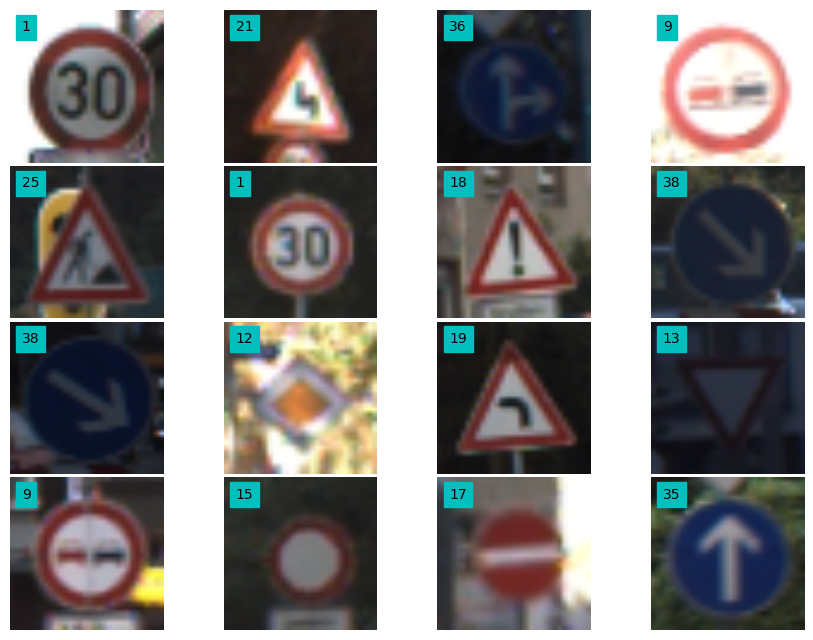

In [10]:
plot_random_3C(4,4,X_train,y_train)

In [11]:
img_resize = 32
N_classes = 43
image_shape = (img_resize,img_resize)
img_size_flat = img_resize*img_resize


image_GS_train = np.array([pre_process_image(X_train[i]) for i in range(len(X_train))],
                          dtype = np.float32)
image_GS_test = np.array([pre_process_image(X_test[i]) for i in range(len(X_test))],
                          dtype = np.float32)

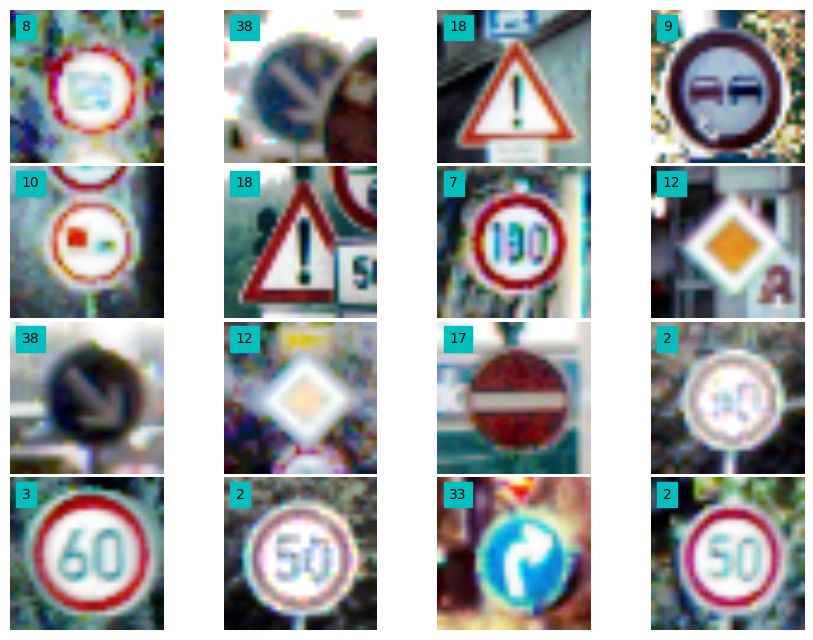

In [12]:
plot_random_3C(4,4,image_GS_train+.5,y_train)

In [13]:
data_i = [[i,sum(y_train == i)] for i in range(len(np.unique(y_train)))]
data_i_sorted = sorted(data_i, key=lambda x: x[1])

In [14]:
data_pd = pd.read_csv('signnames.csv')

In [15]:
data_pd['Occurance'] = pd.Series(np.asarray(data_i_sorted).T[1], index=np.asarray(data_i_sorted).T[0])
data_pd_sorted = data_pd.sort_values(['Occurance'],ascending=[0]).reset_index()
data_pd_sorted = data_pd_sorted.drop('index', 1)


In [16]:
data_pd_sorted.head(10)

,ClassId,SignName,Occurance
0,2,Speed limit (50km/h),2250
1,1,Speed limit (30km/h),2220
2,13,Yield,2160
3,12,Priority road,2100
4,38,Keep right,2070
5,10,No passing for vechiles over 3.5 metric tons,2010
6,4,Speed limit (70km/h),1980
7,5,Speed limit (80km/h),1860
8,25,Road work,1500
9,9,No passing,1470


In [17]:
data_pd_sorted.tail(10)

,ClassId,SignName,Occurance
33,39,Keep left,300
34,29,Bicycles crossing,270
35,24,Road narrows on the right,270
36,41,End of no passing,240
37,42,End of no passing by vechiles over 3.5 metric ...,240
38,32,End of all speed and passing limits,240
39,27,Pedestrians,240
40,37,Go straight or left,210
41,19,Dangerous curve to the left,210
42,0,Speed limit (20km/h),210


<Container object of 43 artists>

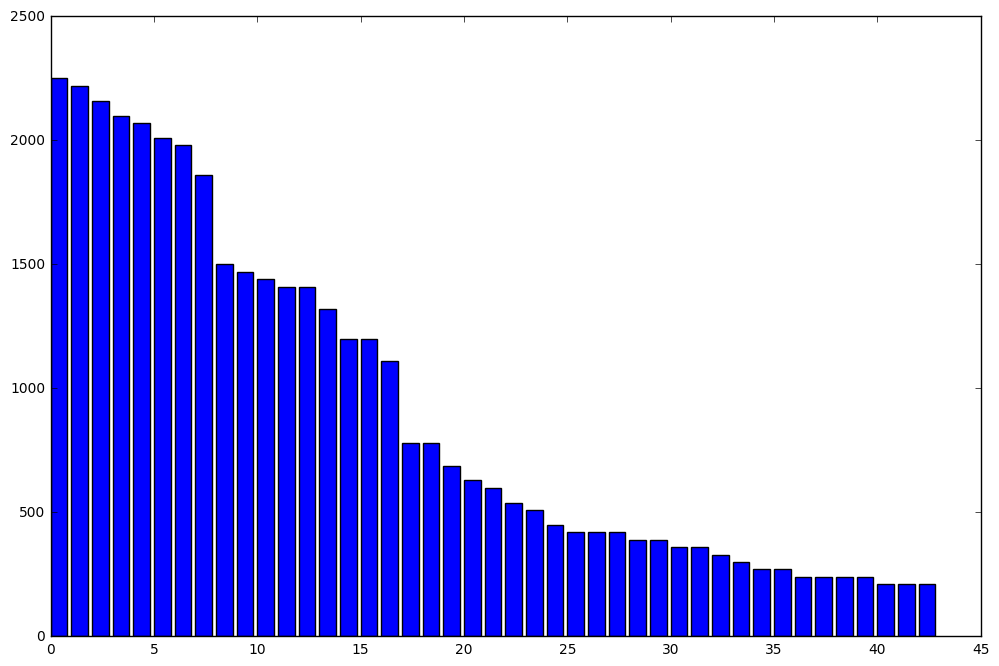

In [18]:
plt.figure(figsize=(12,8))
plt.bar(range(43),height=data_pd_sorted["Occurance"])

In [19]:
img_resize = 32
def transform_image(image,ang_range,shear_range,trans_range):

    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = image.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    image = cv2.warpAffine(image,Rot_M,(cols,rows))
    image = cv2.warpAffine(image,Trans_M,(cols,rows))
    image = cv2.warpAffine(image,shear_M,(cols,rows))
    
    image = pre_process_image(image)
    
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    #image = image[:,:,0]
    #image = cv2.resize(image, (img_resize,img_resize),interpolation = cv2.INTER_CUBIC)
    
    return image

def get_index_dict(y_train):
    # Returns indices of each label
    # Assumes that the labels are 0 to N-1
    dict_indices = {}
    ind_all = np.arange(len(y_train))

    for i in range(len(np.unique(y_train))):
        ind_i = ind_all[y_train == i]
        dict_indices[i] = ind_i
        #print(ind_i)
    return dict_indices

def gen_transformed_data(X_train,y_train,N_classes,n_each,ang_range,shear_range,trans_range,randomize_Var):
   
   dict_indices = get_index_dict(y_train)
   n_class = len(np.unique(y_train))
   X_arr = []
   Y_arr = []
   for i in range(n_class):
       len_i = len(dict_indices[i])
       ind_rand = np.random.randint(0,len_i,n_each)
       ind_dict_class  = dict_indices[i]
       
       for i_n in range(n_each):
           img_trf = transform_image(X_train[ind_dict_class[ind_rand[i_n]]],
                                     ang_range,shear_range,trans_range)
           X_arr.append(img_trf)
           Y_arr.append(i)
           
   X_arr = np.array(X_arr,dtype = np.float32())
   Y_arr = np.array(Y_arr,dtype = np.float32())
   
   if (randomize_Var == 1):
       len_arr = np.arange(len(Y_arr))
       np.random.shuffle(len_arr)
       X_arr[len_arr] = X_arr
       Y_arr[len_arr] = Y_arr
       
   labels_arr = OHE_labels(Y_arr,43)

   return X_arr,Y_arr,labels_arr


def gen_extra_data(X_train,y_train,N_classes,n_each,ang_range,shear_range,trans_range,randomize_Var):
    
    dict_indices = get_index_dict(y_train)
    n_class = len(np.unique(y_train)) 
    X_arr = []
    Y_arr = []
    n_train = len(X_train)
    for i in range(n_train):
        #X_arr.append(transform_image(X_train[i],0,0,0)/255.)
        #Y_arr.append(y_train[i])
        for i_n in range(n_each):
            img_trf = transform_image(X_train[i],
                                      ang_range,shear_range,trans_range)
            X_arr.append(img_trf)
            Y_arr.append(y_train[i])
            
    X_arr = np.array(X_arr,dtype = np.float32())
    Y_arr = np.array(Y_arr,dtype = np.float32())
    
    if (randomize_Var == 1):
        len_arr = np.arange(len(Y_arr))
        np.random.shuffle(len_arr)
        X_arr[len_arr] = X_arr
        Y_arr[len_arr] = Y_arr
        
    labels_arr = OHE_labels(Y_arr,43)

    return X_arr,Y_arr,labels_arr

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**


1. ***Splitting data into training and validation set:*** I first split the data into training and validation sets using sklearn's test_train_split function. I split the data so 10% of the data was validation data and 90% was training data. I then generated 

2. ***Generating addtional data:*** As the training data was limited, I generated additional training data by using the image augmentation techniques presented above. For each image in the original training set, I generated 5 transformed images. By generating 5 additional images, the number of images increased but the the relative number of images in each set did not change. I inetentionally kept the ratio of images in each class the same because we expect to see an uneven distribution of signs in real life too. I started with a large rotation angle, translation and shear range for transforming images in the initial epochs of training. However, after first 4 epochs, I reduced these range by a factor of 0.9 in each epoch.

In [21]:
Image_train_GS_rot,y_train_rot,labels_train_rot = gen_transformed_data(X_train,y_train,
                                                                       43,10,30,5,5,1)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

In [23]:
def random_batch():
    # Number of images in the training-set.
    num_images = len(Image_train_GS_rot_1)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=batch_size,
                           replace=False)

    # Use the random index to select random images and labels.
    features_batch = Image_train_GS_rot_1[idx, :,:,:]
    labels_batch = labels_train_rot[idx, :]

    return features_batch, labels_batch

In [24]:
def get_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
def get_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

def conv_layer(input,
               num_inp_channels,
               filter_size,
               num_filters,
              use_pooling):
    shape = [filter_size, filter_size, num_inp_channels,num_filters]
    weights = get_weights(shape)
    biases = get_biases(num_filters)
    layer = tf.nn.conv2d(input = input,
                        filter = weights,
                        strides = [1,1,1,1],
                        padding = 'SAME')

    layer += biases
    
    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                         ksize=[1, 2, 2, 1],
                         strides=[1, 2, 2, 1],
                         padding='SAME')
    layer = tf.nn.relu(layer)
    
    return layer, weights

In [25]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat, num_features

In [26]:
def fc_layer(input,          # The previous layer.
             num_inputs,     # Num. inputs from prev. layer.
             num_outputs,    # Num. outputs.
             use_relu=True): # Use Rectified Linear Unit (ReLU)?
    weights = get_weights(shape=[num_inputs, num_outputs])
    biases = get_biases(length=num_outputs)
    layer = tf.matmul(input, weights) + biases

    if use_relu:
        layer = tf.nn.relu(layer)

    return layer,weights

def dropout_layer(layer, keep_prob):
    layer_drop = tf.nn.dropout(layer, keep_prob)
    return layer_drop

In [27]:
img_size = 32
num_channels = 3 
Image_train_GS_rot_1 = Image_train_GS_rot
image_GS_test_1 = image_GS_test

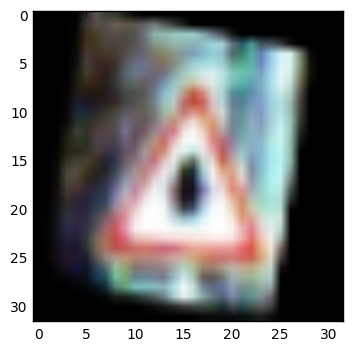

In [28]:
plt.imshow(Image_train_GS_rot_1[5]+.5);

In [29]:
features = tf.placeholder(tf.float32, shape=[None, img_size, img_size,num_channels], 
                   name='features')
labels_true = tf.placeholder(tf.float32,shape=[None,N_classes], name='y_true')

labels_true_cls = tf.argmax(labels_true, dimension=1)


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

<img src="conv_net_sm.png">

Figure above shows the convolutional neural network model I used. I had a one 1X1X3 layer, this is analogous of applying an image transformation (like RGB to YUV), but instead of user defining the color transformation, a 1X1X3 convolutional network allows the neural network to choose the best color map, instead of user specifying it. The next 2 layers were 3X3X32 convolutional layers to extract low level features, I then applied 3X3 maxpooling and dropout with drop probability of 0.5. I repeated this structure two more times with number of filters 64 and 128 to identify higher level features. I took the values after dropout layers from each of the convolution block and concatenated them in a single vector. I used these features as input for training the fully connected layers. I had 2 fully connected layer units with 1024 hidden neurons followed by a dropout layer (p = 0.5) each. 

I tried several other architectures, I started with a simple linear model that got me 92%, I then went to a fully connected neural network that pushed the accuracy to 96%, and I finally switched to convolutional networks that gave me an test accuracy of 98.8%.

In [30]:
## Convlayer 0
filter_size0 = 1
num_filters0 = 3

## Convlayer 1
filter_size1 = 5
num_filters1 = 32
## Convlayer 2
filter_size2 = 5
num_filters2 = 32

## Convlayer 3
filter_size3 = 5
num_filters3 = 64
## Convlayer 4
filter_size4 = 5
num_filters4 = 64

## Convlayer 5
filter_size5 = 5
num_filters5 = 128
## Convlayer 6
filter_size6 = 5
num_filters6 = 128

## FC_size 
fc_size1 = 1024
## FC_size 
fc_size2 = 1024

## Dropout
#drop_prob = 0.5

keep_prob = tf.placeholder(tf.float32)

In [31]:
layer_conv0, weights_conv0 = \
        conv_layer(input=features,
                   num_inp_channels=num_channels,
                   filter_size=filter_size0,
                   num_filters=num_filters0,
                   use_pooling=False)

layer_conv1, weights_conv1 = \
        conv_layer(input=layer_conv0,
                   num_inp_channels=num_filters0,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=False)
layer_conv2, weights_conv2 = \
        conv_layer(input=layer_conv1,
                   num_inp_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)
layer_conv2_drop = dropout_layer(layer_conv2, keep_prob)
    
layer_conv3, weights_conv3 = \
        conv_layer(input=layer_conv2_drop,
                   num_inp_channels=num_filters2,
                   filter_size=filter_size3,
                   num_filters=num_filters3,
                   use_pooling=False)
layer_conv4, weights_conv4= \
        conv_layer(input=layer_conv3,
                   num_inp_channels=num_filters3,
                   filter_size=filter_size4,
                   num_filters=num_filters4,
                   use_pooling=True)
layer_conv4_drop = dropout_layer(layer_conv4, keep_prob)

layer_conv5, weights_conv5 = \
        conv_layer(input=layer_conv4_drop,
                   num_inp_channels=num_filters4,
                   filter_size=filter_size5,
                   num_filters=num_filters5,
                   use_pooling=False)
layer_conv6, weights_conv6 = \
        conv_layer(input=layer_conv5,
                   num_inp_channels=num_filters5,
                   filter_size=filter_size6,
                   num_filters=num_filters6,
                   use_pooling=True)    
layer_conv6_drop = dropout_layer(layer_conv6, keep_prob)


layer_flat2, num_fc_layers2 = flatten_layer(layer_conv2_drop)
layer_flat4, num_fc_layers4 = flatten_layer(layer_conv4_drop)
layer_flat6, num_fc_layers6 = flatten_layer(layer_conv6_drop)

layer_flat = tf.concat(1, [layer_flat2, layer_flat4, layer_flat6])
num_fc_layers = num_fc_layers2+num_fc_layers4+num_fc_layers6

fc_layer1,weights_fc1 = fc_layer(layer_flat,          # The previous layer.
             num_fc_layers,     # Num. inputs from prev. layer.
             fc_size1,    # Num. outputs.
             use_relu=True)
fc_layer1_drop = dropout_layer(fc_layer1, keep_prob)

fc_layer2,weights_fc2 = fc_layer(fc_layer1_drop,          # The previous layer.
             fc_size1,     # Num. inputs from prev. layer.
             fc_size2,    # Num. outputs.
             use_relu=True)
fc_layer2_drop = dropout_layer(fc_layer2, keep_prob)

fc_layer3,weights_fc3 = fc_layer(fc_layer2_drop,          # The previous layer.
             fc_size2,     # Num. inputs from prev. layer.
             n_classes,    # Num. outputs.
             use_relu=False)

labels_pred = tf.nn.softmax(fc_layer3)
labels_pred_cls = tf.argmax(labels_pred, dimension=1)

regularizers = (tf.nn.l2_loss(weights_conv0) 
                + tf.nn.l2_loss(weights_conv1) + tf.nn.l2_loss(weights_conv2) 
                + tf.nn.l2_loss(weights_conv3) + tf.nn.l2_loss(weights_conv4) 
                + tf.nn.l2_loss(weights_conv5) + tf.nn.l2_loss(weights_conv6) 
                + tf.nn.l2_loss(weights_fc1)  + tf.nn.l2_loss(weights_fc2) +
                tf.nn.l2_loss(weights_fc3))

In [32]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=fc_layer3,
                                                        labels=labels_true)

In [33]:
cost = tf.reduce_mean(cross_entropy)+1e-5*regularizers


In [34]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)


In [35]:
correct_prediction = tf.equal(labels_pred_cls, labels_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [36]:
batch_size = 100


In [37]:
def optimize(num_iterations):
    global total_iterations
    global best_validation_accuracy
    global last_improvement
    global best_test_accuracy
    
    global val_acc_list
    global batch_acc_list
    global test_acc_list
    
    #num_iter = np.math.floor(len(labels_train_rot)/batch_size)
    #num_iter = min(num_iter-2,num_iterations)
    num_iter = num_iterations
    for i in range(num_iter):
        total_iterations+=1
        # Get batch for training
        features_batch, labels_true_batch = random_batch()
        #idx = np.arange(batch_size*i,batch_size*(i+1))
        #features_batch = Image_GS_train_rot[idx, :,:,:]
        #labels_true_batch = labels_train_rot[idx, :]f
        feed_dict_batch = {features:features_batch,
                            labels_true: labels_true_batch,
                            keep_prob: 0.5}
        session.run(optimizer,feed_dict = feed_dict_batch)
        
        if ((total_iterations % 200 == 0) or (i == (num_iter - 1))):
            # Calculate the accuracy on the training-set.
            acc_batch = session.run(accuracy, feed_dict=feed_dict_batch)
            acc_valid = session.run(accuracy,feed_dict=feed_dict_valid)
            val_acc_list.append(acc_valid)
            batch_acc_list.append(acc_batch)
            if acc_valid > best_validation_accuracy:
                best_validation_accuracy = acc_valid
                last_improvement = total_iterations
                improved_str = '*'
                saver = tf.train.Saver()
                saver.save(sess=session, save_path='model_best_batch')
            else:
                improved_str = ''
            
            if total_iterations - last_improvement > require_improvement:
                print("No improvement found in a while, stopping optimization.")
                break

            # Message for printing.
            if ((total_iterations % 5000 == 0) or (i == (num_iter - 1))):
                msg = "# {0:>6}, Train Acc.: {1:>6.1%}, Val Acc.: {2:>6.1%}, Test Acc.: {3:>6.1%}"
                acc_test = session.run(accuracy,feed_dict=feed_dict_test)
                
                if best_test_accuracy<acc_test:
                    saver = tf.train.Saver()
                    saver.save(sess=session, save_path='model_best_test')
                    best_test_accuracy = acc_test
                    #print_accuracy()
                # Print it.
                print(msg.format(i+1, acc_batch,acc_valid,
                                     acc_test))
                       

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_

**Answer:**
    
1. *** Hyperparameters***: I chose a learning rate of 1e-3, batch size of 256 and a L-2 regularization on weights of \\( 10^{-5} \\) to avoid overfitting, and ran optimization for a total of 22 epochs. 
2. *** Training/validation data***: I generated tranformed data using the technique described in question 1. However, I reduced the augmentation of images as training progressed. The main idea was to provide very noisy data so the neural network can first learn coarse features, and then reduced augmentation to learn finer features. I performed large image augmentations in the initial 4 epochs, and in the next 18 epochs, I reduced augmentation parameters by a factor of 0.9 per epoch. 
3. *** Epochs ***: I ran a total of 22 epochs for training the neural network. In each epoch, I trained the model for 20000 iterations in the first 4 epochs, but for 10000 in the following 18 iterations. 
3. *** Stopping conditions ***: I used accuracy of validation data as a criteria to monitor if model was overfitting. In the first 4 epochs, I did not use early stopping in the first 4 epochs. But after the first 4 epochs, I stopped training if the validation score didnt improve for 1000 consecutive iterations. 

4. *** Optimization ***: I used adamoptimizer with default settings for optimization. The optimization process itself took about 4 hours. 



In [38]:
def print_accuracy():
    acc = session.run(accuracy,feed_dict=feed_dict_test)
    print("Accuracy on test set: {0:>6.1%}".format(acc))
    
def print_confusion_matrix():
    labels_cls_pred = session.run(labels_pred_cls,feed_dict=feed_dict_test)
    cm = confusion_matrix(y_true = y_test,y_pred = labels_cls_pred)
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(N_classes)
    plt.xticks(tick_marks, range(N_classes))
    plt.yticks(tick_marks, range(N_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
def plot_error_examples():
    correct,labels_cls_pred = session.run([correct_prediction,labels_pred_cls],
                                          feed_dict=feed_dict_test)
    incorrect = (correct == False)
    X_incorrect = X_test[incorrect]
    y_incorrect = y_test[incorrect]
    y_pred = labels_cls_pred[incorrect]
    
    plot_random_3C(3,3,X_incorrect,y_incorrect)

def plot_weights():
    # Get the values for the weights from the TensorFlow variable.
    w = session.run(weights)
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Create figure with 3x4 sub-plots,
    # where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<13:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(image_shape)

            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])

In [39]:
feed_dict_test = {features: image_GS_test_1,
                 labels_true: labels_test,
                 labels_true_cls:y_test,
                 keep_prob:1.0}

In [40]:
session = tf.Session()
session.run(tf.initialize_all_variables())


In [41]:
print_accuracy()

Accuracy on test set:   1.4%


In [43]:
val_acc_list = []
batch_acc_list = []
train_acc_list = []

In [49]:
batch_size = 512


In [52]:
start_time = time.time()
total_iterations = 0
require_improvement = 10000
ang_rot = 10
trans_rot = 2
shear_rot = 2
n_opt = 40000
best_test_accuracy = 0.0
    
for i_train in range(1):
    best_validation_accuracy = 0.0
    last_improvement = 0

    #Image_train_GS_rot,y_train_rot,labels_train_rot = gen_transformed_data(X_train,y_train,43,5000,30,5,5,1)
    
    
    if i_train>-1:
        ang_rot = 10*0.9**(i_train)
        trans_rot = 2*0.9**(i_train)
        shear_rot = 2*0.9**(i_train)
        require_improvement = 5000
        n_opt = 10000
        

        
        
    X_train_SS, X_valid_SS, y_train_SS , y_valid_SS = \
                                train_test_split(X_train,
                                                 y_train,
                                                 test_size=0.1,
                                                 random_state=22)
    labels_valid_SS = OHE_labels(y_valid_SS,43)
    image_GS_valid = np.array([pre_process_image(X_valid_SS[i]) for i in range(len(X_valid_SS))],
                          dtype = np.float32)
    #image_GS_valid = np.reshape(image_GS_valid,(-1,32,32,1))
    
    feed_dict_valid = {features: image_GS_valid,
                 labels_true: labels_valid_SS,
                 labels_true_cls:y_valid_SS,
                 keep_prob:1.0}

    Image_train_GS_rot,y_train_rot,labels_train_rot = gen_extra_data(X_train_SS,y_train_SS,43,5,
                                                                     ang_rot,trans_rot,shear_rot,1)
    print('Optimization Loop # '+str(i_train))    
    Image_train_GS_rot_1 = Image_train_GS_rot 
    #np.reshape(Image_train_GS_rot,(-1,32,32,1))
    #
    optimize(n_opt)
    #print_accuracy()
    
    
end_time = time.time()

time_diff = end_time-start_time

Optimization Loop # 0
#   5000, Train Acc.: 100.0%, Val Acc.:  99.8%, Test Acc.:  98.8%
#  10000, Train Acc.: 100.0%, Val Acc.: 100.0%, Test Acc.:  98.7%


In [61]:
time_diff

1844.364905834198

(0, 800)

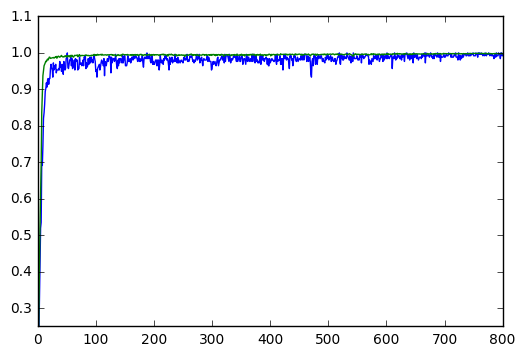

In [74]:
plt.plot(batch_acc_list)
plt.plot(val_acc_list)
plt.ylim(.25,1.1)
plt.xlim(0,800)

### Question 5

_What approach did you take in coming up with a solution to this problem?_

** Answer **

I researched various image identification algorithms developed by researchers. I experimented with different type of models. I experimented with linear, fully connected network, convolutional layer and inception models. However, the convolutional networks gave the best mix of accuracy and speed of training. The final model I came up with is,

<img src="conv_net_sm.png">

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [43]:
saver = tf.train.Saver()
saver.restore(sess=session, save_path='model_best_test')

In [44]:
print_accuracy()

Accuracy on test set:  98.8%


In [64]:
def process_newimage_file(name):
    image = cv2.imread(name)
    image = cv2.resize(image,(32,32))
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = image/255.-.5
    return image

def plot_newImage_3C(n_row,n_col,X):

    plt.figure(figsize = (8,6))
    gs1 = gridspec.GridSpec(n_row,n_row)
    gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes. 

    for i in range(n_row*n_col):
        # i = i + 1 # grid spec indexes from 0
        ax1 = plt.subplot(gs1[i])
        plt.axis('on')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        #plt.subplot(4,11,i+1)
        ind_plot = i
        plt.imshow(X[ind_plot])
        plt.axis('off')
    plt.show()

In [94]:
newdata = [process_newimage_file("./new_signs/"+name) for name in os.listdir("./new_signs/")]
namenewdata = [name for name in os.listdir("./new_signs/")]
newdata = np.array(newdata ,dtype = np.float32)

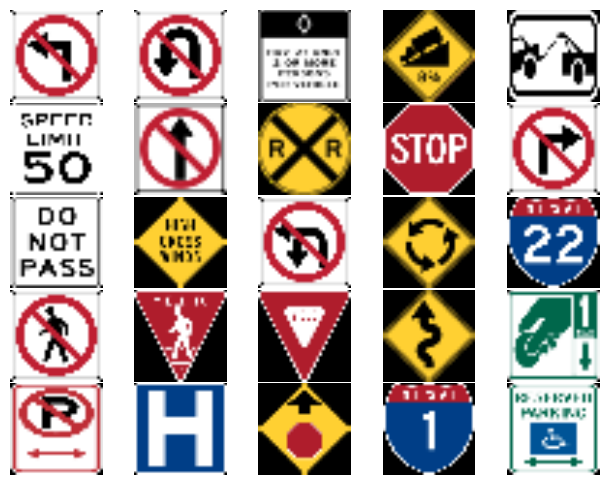

In [66]:
plot_newImage_3C(5,5,newdata+.5)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._


**Answer:**

Images above present 25 images I downloaded from internet. I expect the neural network to perform well on signs that are similar between german and US roads. However, some signs such as US highways and interstates may not be in the german data set, so I expect predictions for those images to be wrong. 

In [72]:
#labels_pred = tf.nn.softmax(fc_layer3)
feed_dict_new = {features:newdata,
                            keep_prob: 1}
top5 = tf.nn.top_k(labels_pred, 5)

predictions = session.run(labels_pred,feed_dict = feed_dict_new)
top5_pred = session.run([labels_pred, top5], feed_dict=feed_dict_new)

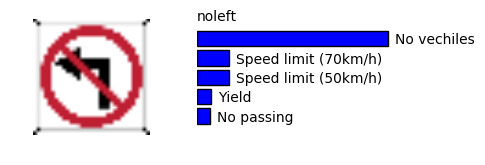

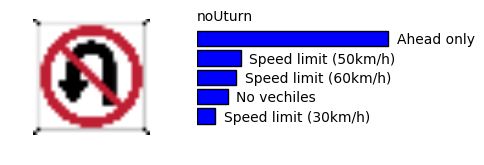

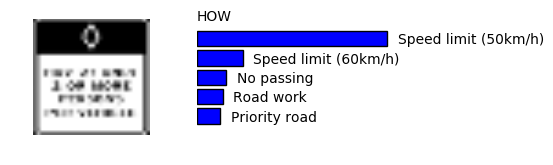

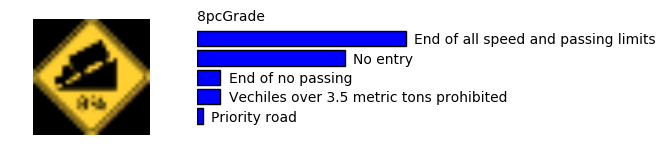

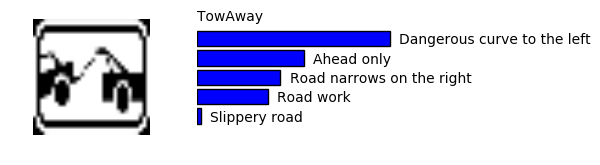

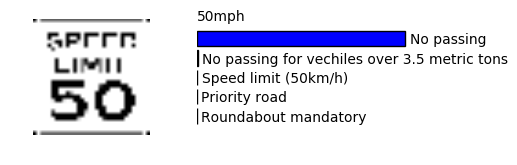

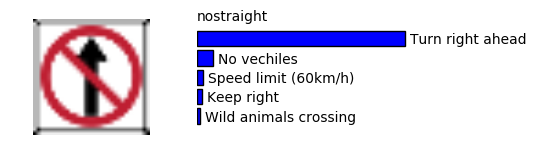

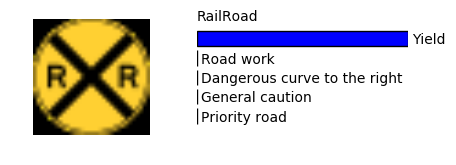

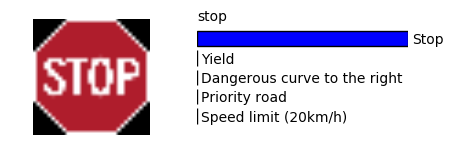

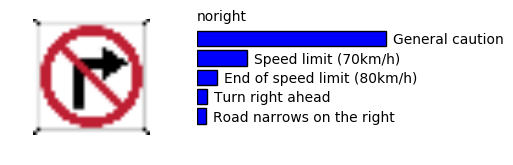

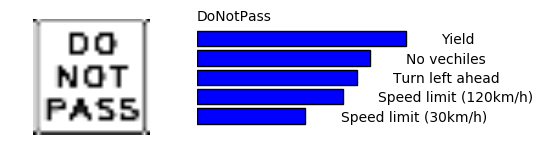

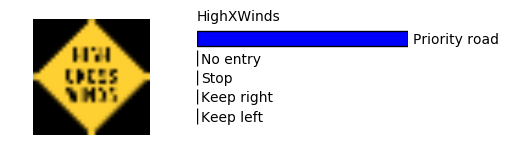

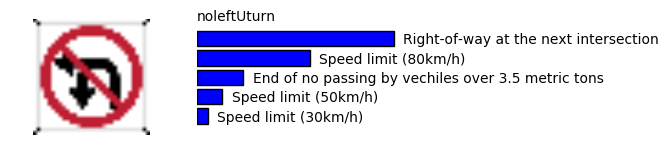

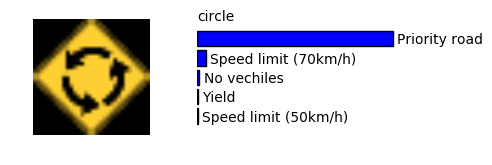

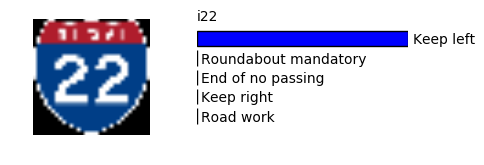

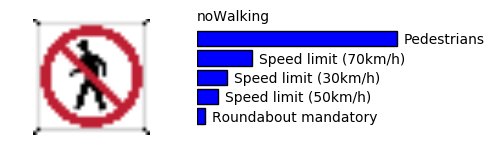

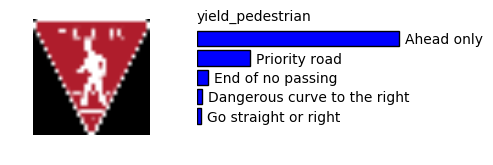

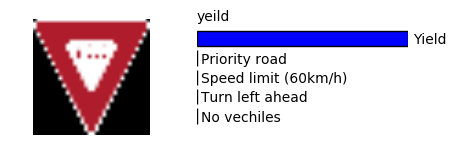

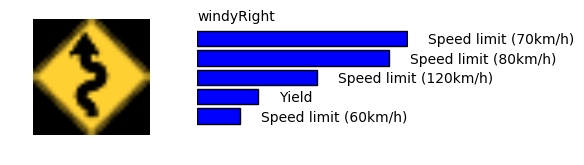

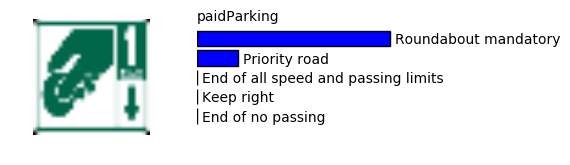

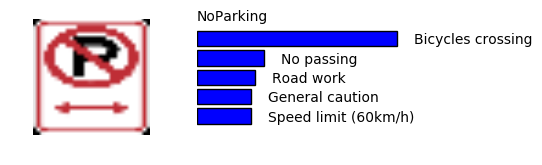

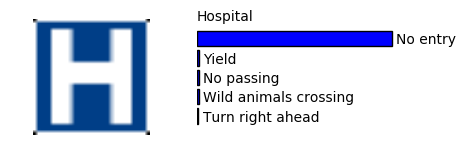

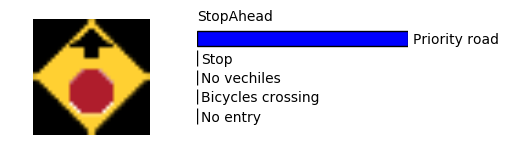

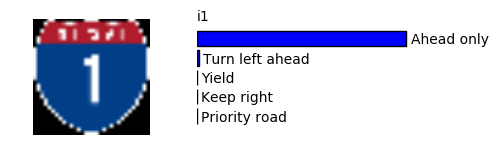

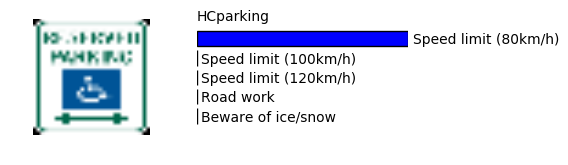

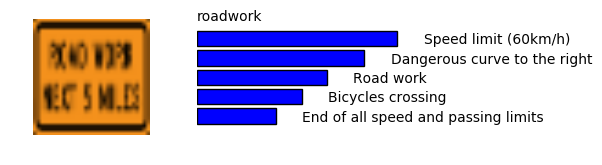

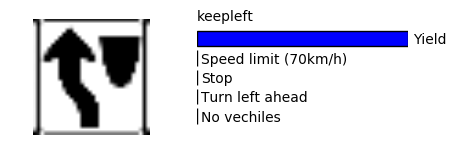

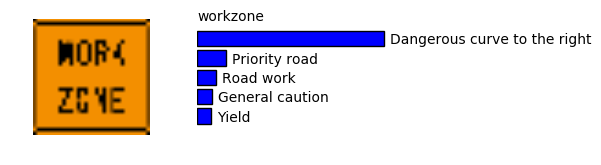

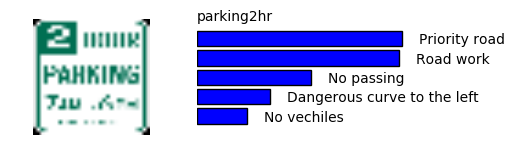

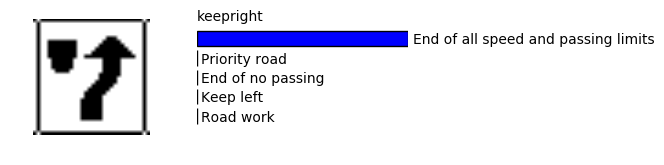

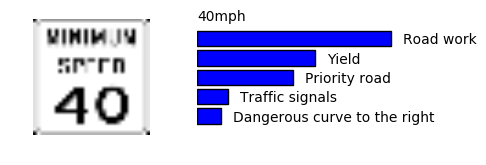

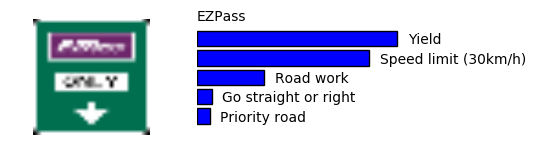

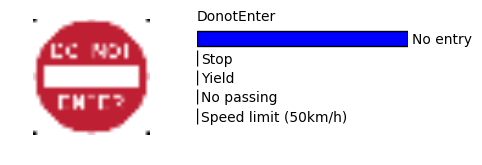

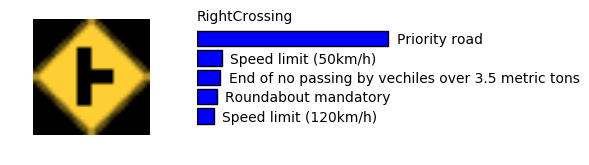

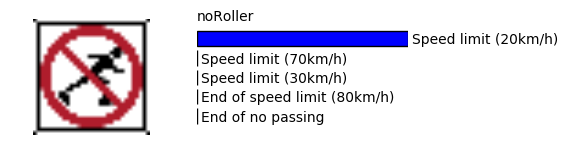

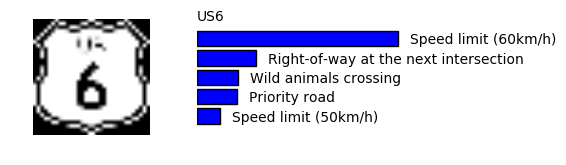

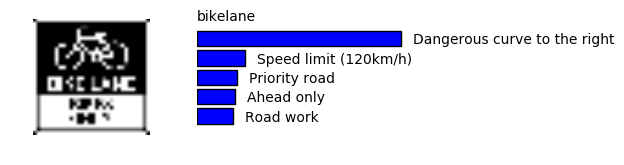

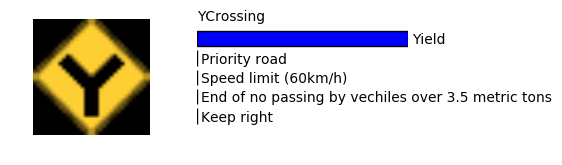

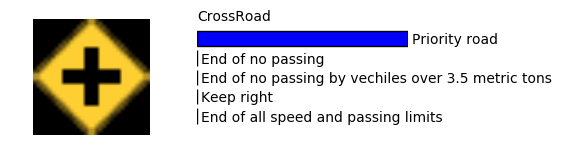

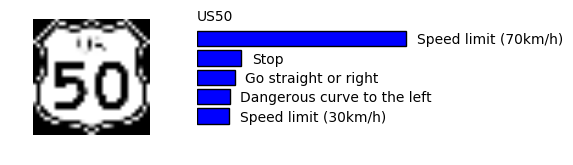

In [191]:
for i in range(40):
    plt.figure(figsize = (5,1.5))
    gs = gridspec.GridSpec(1, 2,width_ratios=[2,3])
    plt.subplot(gs[0])
    plt.imshow(newdata[i]+.5)
    plt.axis('off')
    plt.subplot(gs[1])
    plt.barh(6-np.arange(5),top5_pred[1][0][i], align='center')
    for i_label in range(5):
        plt.text(top5_pred[1][0][i][i_label]+.02,6-i_label-.25,
            data_pd['SignName'][top5_pred[1][1][i][i_label]])
    plt.axis('off');
    plt.text(0,6.95,namenewdata[i].split('.')[0]);
    plt.show();


### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_

** Answer: **
    
The model performed poorely on US sign data. It performed well on signs that look like the signs in Germany (like stop, do not enter, etc). However, for signs that are significantly different from those seen in the training data set, generalization is poor. 

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

** Answer: **

The model is most certain of signs that are similar to signs in the training set (i.e. similar in Germany and USA). The model is very inaccurate for signs that are not similar to the signs in Germany. 

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._

**Answer:**

I did not deploy the classification algorithm as a separate program. I stored the model structure and model weights, and recalled the weights to test predictions on new images. However, a good way to test new images is to develop a simple Flask application that stores the weights and model structures, take in camera image as input and returns predictions based on neural network model. I did not test this in real system. 